<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Goal</a></span></li><li><span><a href="#Var" data-toc-modified-id="Var-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Var</a></span></li><li><span><a href="#Init" data-toc-modified-id="Init-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Init</a></span></li><li><span><a href="#Load" data-toc-modified-id="Load-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load</a></span><ul class="toc-item"><li><span><a href="#Format" data-toc-modified-id="Format-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Format</a></span></li></ul></li><li><span><a href="#Tree-subsample" data-toc-modified-id="Tree-subsample-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Tree subsample</a></span></li><li><span><a href="#RRPP:-diet" data-toc-modified-id="RRPP:-diet-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>RRPP: diet</a></span><ul class="toc-item"><li><span><a href="#Saving-results" data-toc-modified-id="Saving-results-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Saving results</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Summary</a></span></li><li><span><a href="#CI-for-each-OTU-&amp;-diet-based-on-lm.rrpp" data-toc-modified-id="CI-for-each-OTU-&amp;-diet-based-on-lm.rrpp-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>CI for each OTU &amp; diet based on lm.rrpp</a></span><ul class="toc-item"><li><span><a href="#Saving-results" data-toc-modified-id="Saving-results-6.3.1"><span class="toc-item-num">6.3.1&nbsp;&nbsp;</span>Saving results</a></span></li><li><span><a href="#Plotting" data-toc-modified-id="Plotting-6.3.2"><span class="toc-item-num">6.3.2&nbsp;&nbsp;</span>Plotting</a></span></li></ul></li></ul></li><li><span><a href="#RRPP:-digestive-system" data-toc-modified-id="RRPP:-digestive-system-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>RRPP: digestive system</a></span><ul class="toc-item"><li><span><a href="#Saving-results" data-toc-modified-id="Saving-results-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Saving results</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Summary</a></span></li></ul></li><li><span><a href="#RRPP:-diet-+-digSys" data-toc-modified-id="RRPP:-diet-+-digSys-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>RRPP: diet + digSys</a></span><ul class="toc-item"><li><span><a href="#Saving-results" data-toc-modified-id="Saving-results-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Saving results</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Summary</a></span></li></ul></li><li><span><a href="#sessionInfo" data-toc-modified-id="sessionInfo-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>sessionInfo</a></span></li></ul></div>

# Goal

* RRPP analysis to assess correlations of OTUs and host phenotypes while controlling for host phylogeny

# Var

In [1]:
work_dir = '/ebio/abt3_projects/Georg_animal_feces/data/16S_arch/MiSeq-Runs-116-122-126-189-190/LLA/modulating/RRPP/'

# microbiome
## 16S-arch phyloseq object (one sample per individual)
physeq_arch_IndD_file = '/ebio/abt3_projects/Georg_animal_feces/data/16S_arch/MiSeq-Runs-116-122-126-189-190/LLA/merged/phyloseq/physeq_arch_IndD_rare250.RDS'

# host tree
host_tree_IndD_file = '/ebio/abt3_projects/Georg_animal_feces/data/animal/phylogeny/TT/unified_metadata_complete_200429_16S-arch_IndD.nwk'

# misc params
threads = 12
my_seed = 8394

# Init

In [2]:
library(dplyr)
library(tidyr)
library(ggplot2)

library(ape)
library(phyloseq)
library(RRPP)

library(doParallel)
library(LeyLabRMisc)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘RRPP’


The following object is masked from ‘package:phyloseq’:

    ordinate


Loading required package: foreach

Loading required package: iterators

Loading required package: parallel



In [3]:
# cluster job submission
clustermq_setup()
library(clustermq)

Loading required package: clustermq



In [4]:
df.dims()
set.seed(my_seed)
make_dir(work_dir)
RhpcBLASctl::blas_set_num_threads(1)

Directory already exists: /ebio/abt3_projects/Georg_animal_feces/data/16S_arch/MiSeq-Runs-116-122-126-189-190/LLA/modulating/RRPP/ 


# Load

In [5]:
# phyloseq obj.
physeq = readRDS(physeq_arch_IndD_file) %>%
    filter_taxa(function(x) sum(x > 0) >= 2, TRUE) %>%
    prune_samples(sample_sums(.) > 0, .)
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 355 taxa and 185 samples ]
sample_data() Sample Data:       [ 185 samples by 88 sample variables ]
tax_table()   Taxonomy Table:    [ 355 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 355 tips and 354 internal nodes ]

In [6]:
# otu table
otu = physeq %>%
    phyloseq2df(otu_table) %>%
    as.data.frame
rownames(otu) = otu$OTU
otu$OTU = NULL
otu = otu %>% t %>% as.data.frame
colnames(otu) = gsub('^([0-9])', 'X_\\1', colnames(otu))
otu

,c5fbed2bb10ab3a08275a92e9caea3c1,X_1936b1a270b058c5754be0addc7c7c31,X_6668cc03267d4f04b5a34d676c1db57a,X_6e9321684640a05dd16b7bc01b98c14a,X_0c59c44aeb355d3aa4dfa33ac4e77cde,X_2a64fe6cea748d320b2f99fe83449e46,X_458f7b9ac8ea99af3b251a761c878332,X_7950a70a07006f7c7b0c6f02c46a93af,X_9dd5def1c71e9aa144221be97b12d2e6,X_7efd5f90bad3210ac9182784e5882716,⋯,X_95cfc3c342d1f3a2af58c49f6065b08a,f40a4552f05b5c3ca111c9886b7360a0,e50dfa4783c02bc4cbff9d9297e8d844,X_056a6332380b1f40d814d70adc074217,de8bd36d71e9372a6b9e16b54cefa562,X_569a2abee10cb7fdef315334d856b92b,X_890c6bb9fc8dea9dc4b756a645f4f472,b171d5cdecd235e7199d44ce8991794d,X_36fd5c55ad082f4d05194157da9d13da,d7dd0bdd8184f8cb7189e1e09afa97d0
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F14_Common_Bream,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0.0
F35_Red_Deer,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,3.6
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
X431_Quagga,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
X67_European_Roe,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [7]:
# metadata
metadata = physeq %>% 
    phyloseq2df(sample_data) %>%
    mutate(scientific_name = gsub(' ', '_', scientific_name),
           digestive_system = gsub('fermentation activity ', '', digestive_system),
           dig_sys = gsub('simple ', '', digestive_system)) %>%
    as.data.frame
rownames(metadata) = metadata$SampleID
metadata 

,SampleID,host_subject_id,host_german_name,host_common_name,scientific_name,scientific_name_subspecies,host_taxid,class,order,family,⋯,i.CH4_L.d_mean,i.CH4_L.d_sd,i.CH4_L.kgBM_mean,i.CH4_L.kgBM_sd,i.CH4_g.d_mean,i.CH4_g.d_sd,i.CH4_kJ.d_mean,i.CH4_kJ.d_sd,Sample,dig_sys
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
F14_Common_Bream,F14_Common_Bream,F14,Brachse,Common.Bream,Abramis_brama,NA,38527,Actinopterygii,Cypriniformes,Cyprinidae,⋯,NA,NA,NA,NA,NA,NA,NA,NA,F14_Common_Bream,simple
F35_Red_Deer,F35_Red_Deer,F35,Rothirsch,Red.Deer,Cervus_elaphus,NA,9860,Mammalia,Artiodactyla,Cervidae,⋯,52.24132,27.18306,0.4858472,0.1686955,38.67117,21.30162,2066.942,1075.505,F35_Red_Deer,foregut
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
X431_Quagga,X431_Quagga,431,Steppenzebra,Quagga,Equus_quagga,NA,89252,Mammalia,Perissodactyla,Equidae,⋯,NA,NA,NA,NA,NA,NA,NA,NA,X431_Quagga,hindgut
X67_European_Roe,X67_European_Roe,67,Reh,European.Roe,Capreolus_capreolus,NA,9858,Mammalia,Artiodactyla,Cervidae,⋯,NA,NA,NA,NA,NA,NA,NA,NA,X67_European_Roe,foregut


In [8]:
# host phylogeny
host_tree = read.tree(host_tree_IndD_file)
host_tree


Phylogenetic tree with 185 tips and 184 internal nodes.

Tip labels:
	X60_European_Chub, X179_Roach, X330_Ide, X327_Silver_Bream, X326_Silver_Bream, F14_Common_Bream, ...
Node labels:
	, @_20_@, @_17_@, @_14_@, @_9_@, @_15_@, ...

Rooted; includes branch lengths.

## Format

In [9]:
diet_vars = c(
'diet',
'diet_vertebrate',
'diet_invertebrate',
'diet_fruit',
'diet_flowers_nectar_pollen',
'diet_leaves_branches_bark_buds',
'diet_seeds',
'diet_grass_waterplants',
'diet_roots_tubers',
'digestive_system',
'dig_sys'
)
otu = cbind(metadata[,diet_vars], otu)
colnames(otu) = gsub('^([0-9])', 'X\\1', colnames(otu))
otu

,diet,diet_vertebrate,diet_invertebrate,diet_fruit,diet_flowers_nectar_pollen,diet_leaves_branches_bark_buds,diet_seeds,diet_grass_waterplants,diet_roots_tubers,digestive_system,⋯,X_95cfc3c342d1f3a2af58c49f6065b08a,f40a4552f05b5c3ca111c9886b7360a0,e50dfa4783c02bc4cbff9d9297e8d844,X_056a6332380b1f40d814d70adc074217,de8bd36d71e9372a6b9e16b54cefa562,X_569a2abee10cb7fdef315334d856b92b,X_890c6bb9fc8dea9dc4b756a645f4f472,b171d5cdecd235e7199d44ce8991794d,X_36fd5c55ad082f4d05194157da9d13da,d7dd0bdd8184f8cb7189e1e09afa97d0
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F14_Common_Bream,omnivore,no,yes,no,no,no,no,yes,no,simple,⋯,0,0,0,0,0,0,0,0,0,0.0
F35_Red_Deer,herbivore,no,no,yes,no,yes,yes,yes,yes,foregut,⋯,0,0,0,0,0,0,0,0,0,3.6
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
X431_Quagga,herbivore,no,no,no,no,no,yes,yes,no,hindgut,⋯,0,0,0,0,0,0,0,0,0,0
X67_European_Roe,herbivore,no,no,yes,no,yes,yes,yes,no,foregut,⋯,0,0,0,0,0,0,0,0,0,0


# Tree subsample

In [10]:
#' randomly selecting one per group
tree_subsample = function(L, df, tree){
    # get subsample (note: subsampling within each species)
    to_keep = df %>% 
        group_by(scientific_name) %>% 
        sample_n(1) %>%
        .$sample
    # subsampling tree
    to_rm = setdiff(tree$tip.label, to_keep)
    tree = drop.tip(tree, to_rm)
    return(tree)
}

In [11]:
# replicate analyses with different subsets of the host phylogeny
n_reps = 100

In [12]:
# permuted trees
df = metadata %>%
    mutate(sample = SampleID) %>%
    dplyr::select(sample, scientific_name) 

doParallel::registerDoParallel(threads)
host_tree_l = plyr::llply(as.list(1:n_reps), 
                          function(x) tree_subsample(x, df, host_tree),
                          .parallel=TRUE)
host_tree_l %>% length

[1] 100

# RRPP: diet

In [34]:
.rrpp_diet = function(tree, taxon, otu, iter=999){
    # tree
    PhyCov = ape::vcv(tree, model = "Brownian")
    # otu
    otu_f = otu[rownames(PhyCov),]
    data = list(OTUs = otu_f[,taxon] %>% as.matrix,
                diet = otu_f$diet)
    names(data[['diet']]) = rownames(otu_f)
    # rrpp
    fitGLS = lm.rrpp(OTUs ~ diet, data = data, Cov = PhyCov,
                     print.progress = FALSE, SS.type = "II", iter = iter)
    anova(fitGLS)$table
}

rrpp_diet = function(taxon, otu, trees, iter=999){
    #doParallel::registerDoParallel(threads)
    df = trees %>% 
        plyr::llply(.rrpp_diet, taxon=taxon, otu=otu, iter=iter, .parallel=FALSE) %>%
        do.call(rbind, .) %>%
        mutate(feature = gsub('[0-9]+$', '', rownames(.))) %>%
        filter(feature == 'diet') 
    df$taxon = taxon
    return(df)   
}

In [35]:
#running for all OTUs & all trees
taxa = physeq %>% taxa_names %>% gsub('^([0-9])', 'X_\\1', .)
taxa %>% length %>% cat('Number of OTUs:', ., '\n')

doParallel::registerDoParallel(threads)
rrpp_res = taxa %>%
    plyr::llply(rrpp_diet, otu, host_tree_l, iter=999, .parallel=TRUE) %>%
    do.call(rbind, .)
rrpp_res

Number of OTUs: 355 


Df,SS,MS,Rsq,F,Z,Pr(>F),feature,taxon
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
2,0.00000000,0.00000000,NaN,NaN,NaN,1.000,diet,c5fbed2bb10ab3a08275a92e9caea3c1
2,0.04940385,0.02470192,0.06990181,4.020809,1.465751,0.044,diet,c5fbed2bb10ab3a08275a92e9caea3c1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
2,4.493974e-07,2.246987e-07,9.003503e-06,0.0004816918,-4.293533,1.000,diet,d7dd0bdd8184f8cb7189e1e09afa97d0
2,2.133493e-07,1.066746e-07,1.136922e-05,0.0006082600,-3.939092,0.997,diet,d7dd0bdd8184f8cb7189e1e09afa97d0


## Saving results

In [13]:
# output file
outF = file.path(work_dir, 'RRPP_lm_otu-diet_rare250.RDS')
outF

[1] "/ebio/abt3_projects/Georg_animal_feces/data/16S_arch/MiSeq-Runs-116-122-126-189-190/LLA/modulating/RRPP//RRPP_lm_otu-diet_rare250.RDS"

In [37]:
# saving
saveRDS(rrpp_res, outF)
cat('File written:', outF)

File written: /ebio/abt3_projects/Georg_animal_feces/data/16S_arch/MiSeq-Runs-116-122-126-189-190/LLA/modulating/RRPP//RRPP_lm_otu-diet_rare250.RDS

In [14]:
# reload 
rrpp_res = readRDS(outF)
rrpp_res

Df,SS,MS,Rsq,F,Z,Pr(>F),feature,taxon
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
2,0.00000000,0.00000000,NaN,NaN,NaN,1.000,diet,c5fbed2bb10ab3a08275a92e9caea3c1
2,0.04940385,0.02470192,0.06990181,4.020809,1.465751,0.044,diet,c5fbed2bb10ab3a08275a92e9caea3c1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
2,4.493974e-07,2.246987e-07,9.003503e-06,0.0004816918,-4.293533,1.000,diet,d7dd0bdd8184f8cb7189e1e09afa97d0
2,2.133493e-07,1.066746e-07,1.136922e-05,0.0006082600,-3.939092,0.997,diet,d7dd0bdd8184f8cb7189e1e09afa97d0


In [39]:
send_email('http://127.0.0.1:9805/notebooks/notebooks/16S_arch/MiSeq-Runs116-122-126-189-190/03_modulating_factors/05a_RRPP_rare250.ipynb')

Sending email to: nyoungblut@tuebingen.mpg.de



## Summary

In [15]:
# formatting
rrpp_res_s = rrpp_res %>%
    rename('P' = `Pr(>F)`) %>%
    group_by(taxon) %>%
    mutate(P = (length(P) - sum(P < 0.05)) / length(P)) %>%
    ungroup() %>%
    mutate(Q = p.adjust(P, method='BH'))

rrpp_res_s %>% .$Q %>% summary_x('Adj. P')
rrpp_res_s

,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,sd,sd_err_of_mean
Adj. P,0,1,1,0.9577465,1,1,0.405,0.165


Df,SS,MS,Rsq,F,Z,P,feature,taxon,Q
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
2,0.00000000,0.00000000,NaN,NaN,NaN,0.83,diet,c5fbed2bb10ab3a08275a92e9caea3c1,1
2,0.04940385,0.02470192,0.06990181,4.020809,1.465751,0.83,diet,c5fbed2bb10ab3a08275a92e9caea3c1,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
2,4.493974e-07,2.246987e-07,9.003503e-06,0.0004816918,-4.293533,1,diet,d7dd0bdd8184f8cb7189e1e09afa97d0,1
2,2.133493e-07,1.066746e-07,1.136922e-05,0.0006082600,-3.939092,1,diet,d7dd0bdd8184f8cb7189e1e09afa97d0,1


In [16]:
# significant taxa
tax = physeq %>%
    phyloseq2df(tax_table) %>%
    mutate(OTU = gsub('^([0-9])', 'X_\\1', OTU))

rrpp_res_s_f = rrpp_res_s %>%
    filter(Q < 0.05) %>%
    inner_join(tax, c('taxon'='OTU'))
rrpp_res_s_f

Df,SS,MS,Rsq,F,Z,P,feature,taxon,Q,Domain,Phylum,Class,Order,Family,Genus,Species
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2,2.109800,1.054900,0.4822527,49.83226,2.95950,0,diet,cbb2255f73a84a2c3aa7bfb7eff84c20,0,Archaea,Euryarchaeota,Thermoplasmata,Methanomassiliicoccales,Methanomethylophilaceae,Candidatus Methanomethylophilus,Methanoculleus sp. CAG:1088
2,2.746763,1.373382,0.3873584,33.82674,3.07867,0,diet,cbb2255f73a84a2c3aa7bfb7eff84c20,0,Archaea,Euryarchaeota,Thermoplasmata,Methanomassiliicoccales,Methanomethylophilaceae,Candidatus Methanomethylophilus,Methanoculleus sp. CAG:1088
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
2,0.08795269,0.04397635,0.06220072,3.548455,1.512421,0,diet,f42715df4a63ee65b59fe0ba60405552,0,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanosphaera,unclassified
2,1.21748011,0.60874005,0.09277461,5.471013,1.791955,0,diet,f42715df4a63ee65b59fe0ba60405552,0,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanosphaera,unclassified


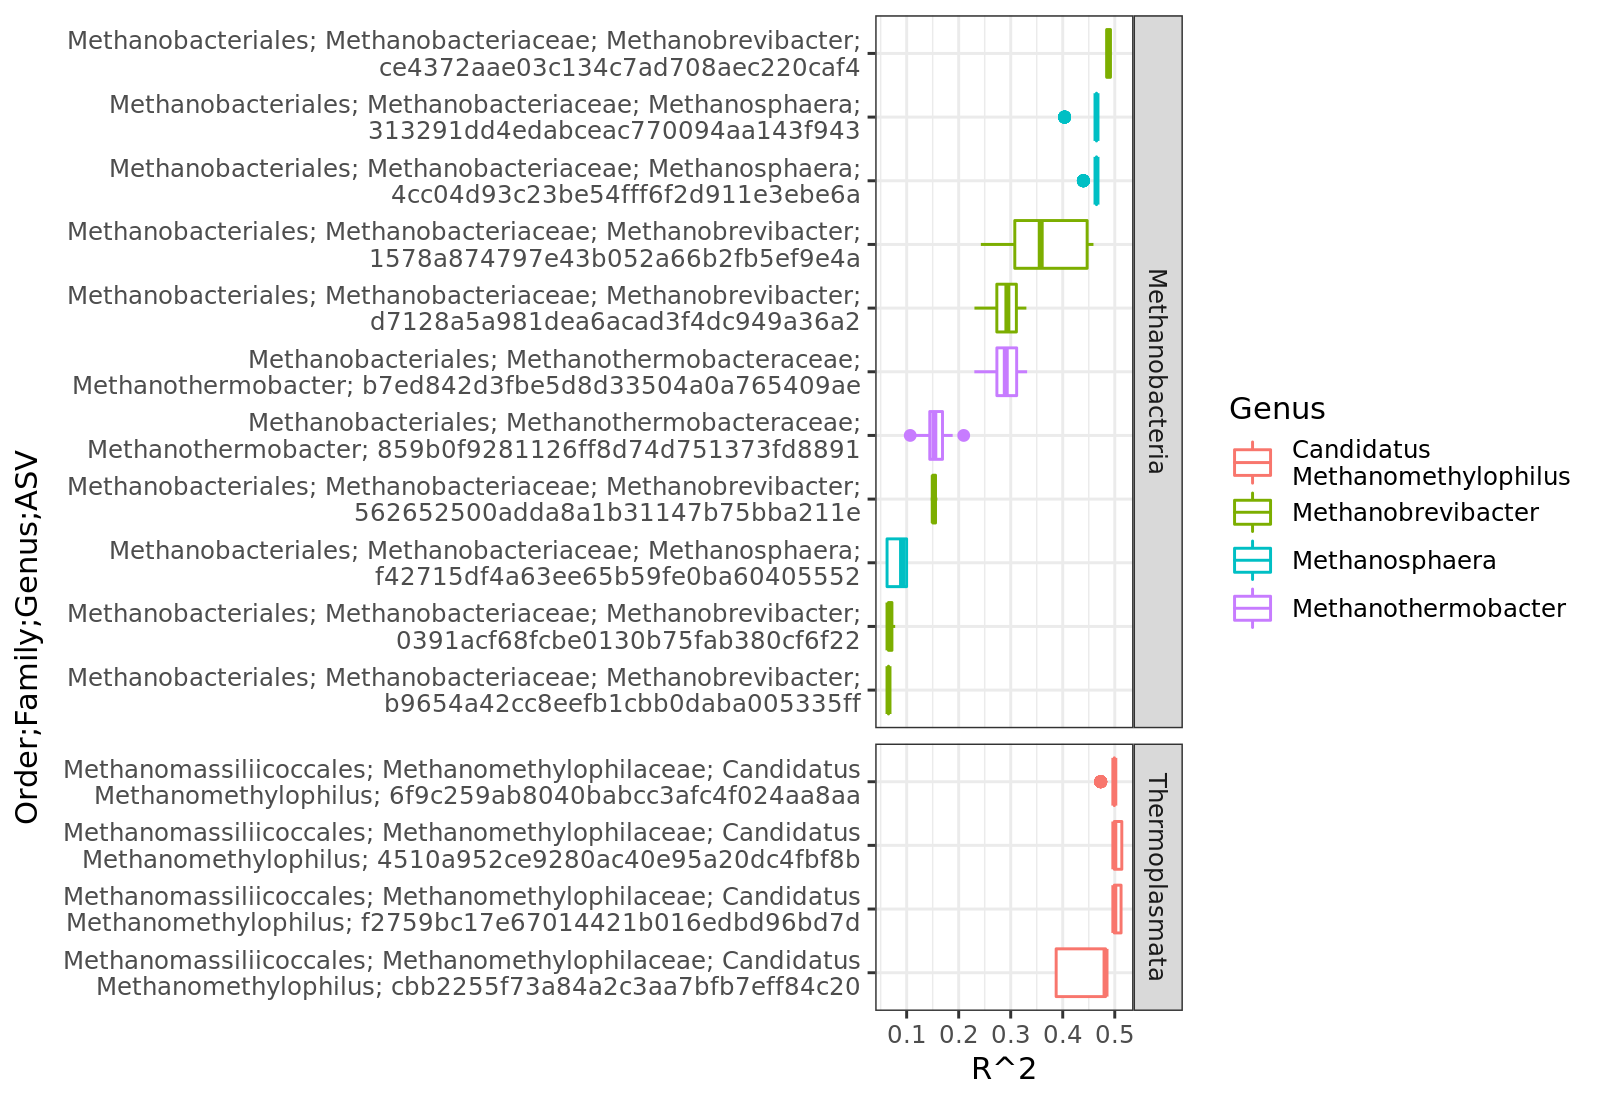

In [17]:
# plotting
p = rrpp_res_s_f %>%
    mutate(taxon = gsub('^X_', '', taxon)) %>%
    #mutate(taxon = taxon %>% as.factor %>% as.numeric %>% gsub('^', 'ASV-', .)) %>%
    mutate(Taxonomy = paste(Order, Family, Genus, taxon, sep='; '),
           Genus = gsub(' ', '\n', Genus),
           Taxonomy = stringr::str_wrap(Taxonomy, 60)) %>%
    group_by(Taxonomy) %>%
    mutate(mean_Rsq = median(Rsq)) %>%
    ungroup() %>%
    mutate(Taxonomy = Taxonomy %>% reorder(mean_Rsq)) %>%
    ggplot(aes(Taxonomy, Rsq, color=Genus)) +
    geom_boxplot() +
    facet_grid(Class ~ ., scales='free_y', space='free_y') +
    labs(x='Order;Family;Genus;ASV', y='R^2') +
    theme_bw() +
    theme(
        axis.title.y = element_text(hjust = 0.3)
    ) +
    coord_flip()

p.dims(8,5.5)
plot(p)

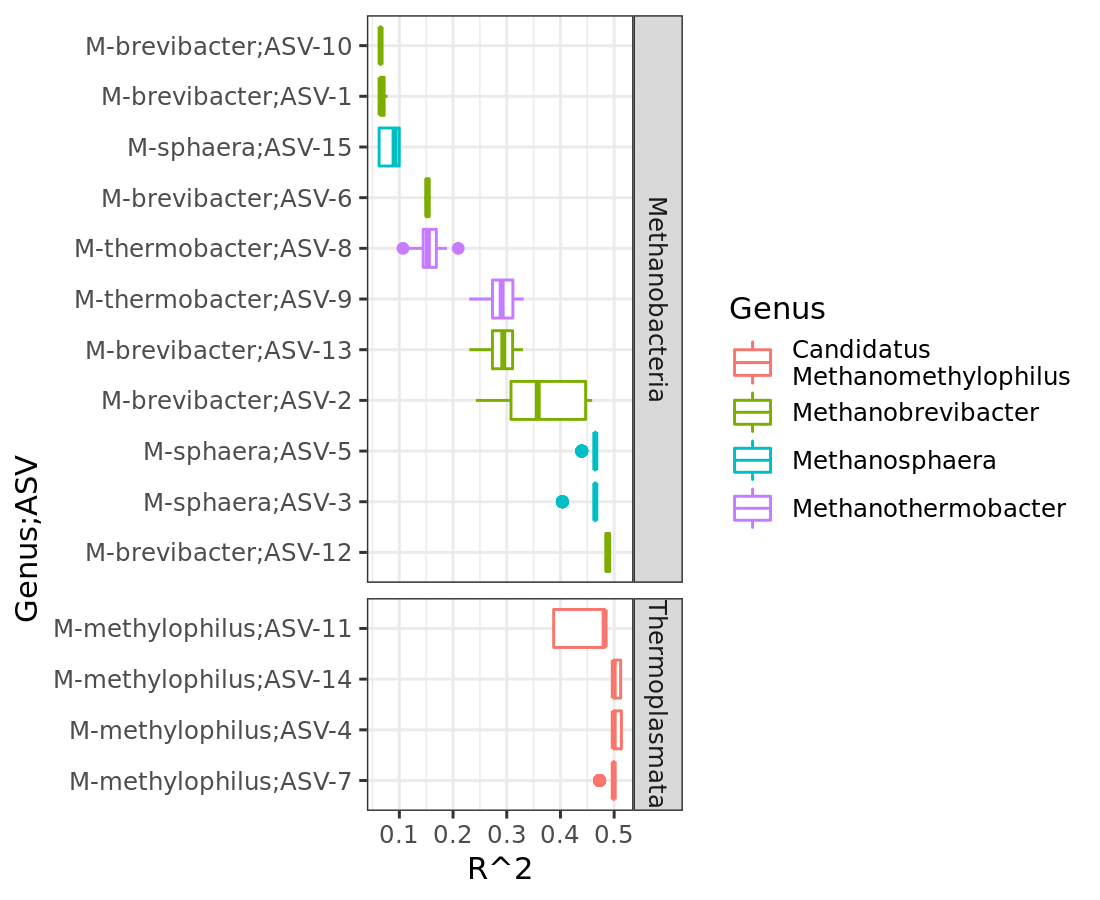

In [85]:
# plotting
p = rrpp_res_s_f %>%
    mutate(taxon = gsub('^X_', '', taxon)) %>%
    mutate(taxon = taxon %>% as.factor %>% as.numeric %>% gsub('^', 'ASV-', .)) %>%
    mutate(Taxonomy = paste(Genus, taxon, sep=';'),
           Genus = gsub(' ', '\n', Genus)) %>%
    mutate(Taxonomy = gsub('Methano', 'M-', Taxonomy),
           Taxonomy = gsub('Candidatus ', '', Taxonomy)) %>%
    group_by(Taxonomy) %>%
    mutate(mean_Rsq = median(Rsq)) %>%
    ungroup() %>%
    mutate(Taxonomy = Taxonomy %>% reorder(-mean_Rsq)) %>%
    ggplot(aes(Taxonomy, Rsq, color=Genus)) +
    geom_boxplot() +
    #facet_grid(. ~ Class, scales='free_x', space='free_x') +
    facet_grid(Class ~ ., scales='free_y', space='free_y') +
    labs(x='Genus;ASV', y='R^2') +
    theme_bw() +
    theme(
        #axis.text.x = element_text(angle=55, hjust=1),
        axis.title.y = element_text(hjust = 0.3)
    ) +
    coord_flip()

#p.dims(8.5,3)
p.dims(5.5,4.5)
plot(p)

## CI for each OTU & diet based on lm.rrpp

In [40]:
.rrpp_diet = function(tree, taxon, otu, iter=999){
    # tree
    PhyCov = ape::vcv(tree, model = "Brownian")
    # otu
    otu_f = otu[rownames(PhyCov),]
    data = list(OTUs = otu_f[,taxon] %>% as.matrix,
                diet = otu_f$diet)
    names(data[['diet']]) = rownames(otu_f)
    # rrpp
    fitGLS = lm.rrpp(OTUs ~ diet, data = data, Cov = PhyCov,
                     print.progress = FALSE, SS.type = "II", iter = iter)
    # results
    x = c('carnivore', 'herbivore', 'omnivore')
    X = data.frame(diet = x)
    rownames(X) = x
    res = predict(fitGLS, X)
    res = cbind(res$mean, res$lcl, res$ucl) %>%
        as.data.frame
    return(res)
}

rrpp_diet = function(taxon, otu, trees, iter=999){
    #doParallel::registerDoParallel(threads)
    df = trees %>% 
        plyr::llply(.rrpp_diet, taxon=taxon, otu=otu, iter=iter, .parallel=FALSE) %>%
        do.call(rbind, .) %>%
        mutate(feature = gsub('[0-9]+$', '', rownames(.))) 
    df$taxon = taxon
    return(df)   
}

In [41]:
# significant OTUs
sig_otus = rrpp_res_s_f$taxon %>% unique #%>% gsub('^X_', '', .)
sig_otus 

[1] "cbb2255f73a84a2c3aa7bfb7eff84c20"   "X_6f9c259ab8040babcc3afc4f024aa8aa"
 [3] "f2759bc17e67014421b016edbd96bd7d"   "X_4510a952ce9280ac40e95a20dc4fbf8b"
 [5] "b9654a42cc8eefb1cbb0daba005335ff"   "ce4372aae03c134c7ad708aec220caf4"  
 [7] "X_562652500adda8a1b31147b75bba211e" "X_1578a874797e43b052a66b2fb5ef9e4a"
 [9] "d7128a5a981dea6acad3f4dc949a36a2"   "X_0391acf68fcbe0130b75fab380cf6f22"
[11] "X_859b0f9281126ff8d74d751373fd8891" "b7ed842d3fbe5d8d33504a0a765409ae"  
[13] "X_4cc04d93c23be54fff6f2d911e3ebe6a" "X_313291dd4edabceac770094aa143f943"
[15] "f42715df4a63ee65b59fe0ba60405552"

In [42]:
# getting CI for each taxon for each diet
doParallel::registerDoParallel(threads)
rrpp_res = sig_otus %>%
    plyr::llply(rrpp_diet, otu, host_tree_l, iter=9999, .parallel=TRUE) %>%
    do.call(rbind, .)
colnames(rrpp_res) = c('mean', 'lcl', 'ucl', 'feature', 'taxon')
rrpp_res

mean,lcl,ucl,feature,taxon
<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.525387,-0.2733895,1.7180019,carnivore,cbb2255f73a84a2c3aa7bfb7eff84c20
-1.202081,-2.9398809,0.6537278,herbivore,cbb2255f73a84a2c3aa7bfb7eff84c20
⋮,⋮,⋮,⋮,⋮
0.3484058,-0.3197392,1.0719728,herbivore,f42715df4a63ee65b59fe0ba60405552
-0.1006919,-0.5124274,0.3358638,omnivore,f42715df4a63ee65b59fe0ba60405552


### Saving results

In [48]:
# output file
outF = file.path(work_dir, 'RRPP_lm_otu-diet_rare250_CI.RDS')
outF

[1] "/ebio/abt3_projects/Georg_animal_feces/data/16S_arch/MiSeq-Runs-116-122-126-189-190/LLA/modulating/RRPP//RRPP_lm_otu-diet_rare250_CI.RDS"

In [49]:
# saving
saveRDS(rrpp_res, outF)
cat('File written:', outF)

File written: /ebio/abt3_projects/Georg_animal_feces/data/16S_arch/MiSeq-Runs-116-122-126-189-190/LLA/modulating/RRPP//RRPP_lm_otu-diet_rare250_CI.RDS

In [50]:
# reload 
rrpp_res = readRDS(outF)
rrpp_res

mean,lcl,ucl,feature,taxon
<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.525387,-0.2733895,1.7180019,carnivore,cbb2255f73a84a2c3aa7bfb7eff84c20
-1.202081,-2.9398809,0.6537278,herbivore,cbb2255f73a84a2c3aa7bfb7eff84c20
⋮,⋮,⋮,⋮,⋮
0.3484058,-0.3197392,1.0719728,herbivore,f42715df4a63ee65b59fe0ba60405552
-0.1006919,-0.5124274,0.3358638,omnivore,f42715df4a63ee65b59fe0ba60405552


In [51]:
send_email('http://127.0.0.1:9805/notebooks/notebooks/16S_arch/MiSeq-Runs116-122-126-189-190/03_modulating_factors/05a_RRPP_rare250.ipynb')

Sending email to: nyoungblut@tuebingen.mpg.de



### Plotting

In [43]:
# formatting
tax = physeq %>%
    phyloseq2df(tax_table) %>%
    mutate(OTU = gsub('^([0-9])', 'X_\\1', OTU))

rrpp_res_j = rrpp_res %>%
    group_by(taxon, feature) %>%
    summarize(mean = mean(mean),
              lcl = mean(lcl),
              ucl = mean(ucl),
              .groups='drop') %>%
    inner_join(tax, c('taxon'='OTU')) 
rrpp_res_j

taxon,feature,mean,lcl,ucl,Domain,Phylum,Class,Order,Family,Genus,Species
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
b7ed842d3fbe5d8d33504a0a765409ae,carnivore,5.9558708,2.555945,9.432043,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanothermobacteraceae,Methanothermobacter,unclassified
b7ed842d3fbe5d8d33504a0a765409ae,herbivore,-0.8657054,-8.634767,6.850355,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanothermobacteraceae,Methanothermobacter,unclassified
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
X_859b0f9281126ff8d74d751373fd8891,herbivore,2.223509,-5.012830,9.243595,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanothermobacteraceae,Methanothermobacter,Methanothermobacter marburgensis str. Marburg
X_859b0f9281126ff8d74d751373fd8891,omnivore,7.893725,4.540586,11.286965,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanothermobacteraceae,Methanothermobacter,Methanothermobacter marburgensis str. Marburg


In [44]:
# for ordering
X = rrpp_res_s_f %>%
    mutate(taxon = gsub('^X_', '', taxon)) %>%
    mutate(Taxonomy = paste(Order, Family, Genus, taxon, sep='; '),
           Taxonomy = stringr::str_wrap(Taxonomy, 60)) %>%
    group_by(Taxonomy) %>%
    summarize(mean_Rsq = median(Rsq), .groups='drop')
X

Taxonomy,mean_Rsq
<chr>,<dbl>
Methanobacteriales; Methanobacteriaceae; Methanobrevibacter; 0391acf68fcbe0130b75fab380cf6f22,0.06508639
Methanobacteriales; Methanobacteriaceae; Methanobrevibacter; 1578a874797e43b052a66b2fb5ef9e4a,0.35765757
⋮,⋮
Methanomassiliicoccales; Methanomethylophilaceae; Candidatus Methanomethylophilus; cbb2255f73a84a2c3aa7bfb7eff84c20,0.4822527
Methanomassiliicoccales; Methanomethylophilaceae; Candidatus Methanomethylophilus; f2759bc17e67014421b016edbd96bd7d,0.4991620


In [53]:
# # plotting
# p = rrpp_res_j %>%
#     mutate(taxon = gsub('^X_', '', taxon)) %>%
#     mutate(Taxonomy = paste(Order, Family, Genus, taxon, sep='; '),
#            Taxonomy = stringr::str_wrap(Taxonomy, 60)) %>%
#     inner_join(X, c('Taxonomy')) %>%
#     mutate(Taxonomy = Taxonomy %>% reorder(mean_Rsq)) %>%
#     ggplot(aes(Taxonomy, mean, color=feature)) +
#     geom_pointrange(position = position_dodge(width = 0.5),
#                     aes(ymin=lcl, ymax=ucl, size=mean_Rsq), alpha=0.7) +
#     scale_size_continuous('R^2', range = c(0.2, 0.7)) +
#     scale_color_discrete('Diet') +
#     facet_grid(Class ~ ., scales='free_y', space='free_y') +
#     labs(x='Order;Family;Genus;ASV', y='Abundance (%)') +
#     theme_bw() +
#     theme(
#         axis.title.y = element_text(hjust = 0.3)
#     ) +
#     coord_flip()

# p.dims(8.5,4.5)
# plot(p)

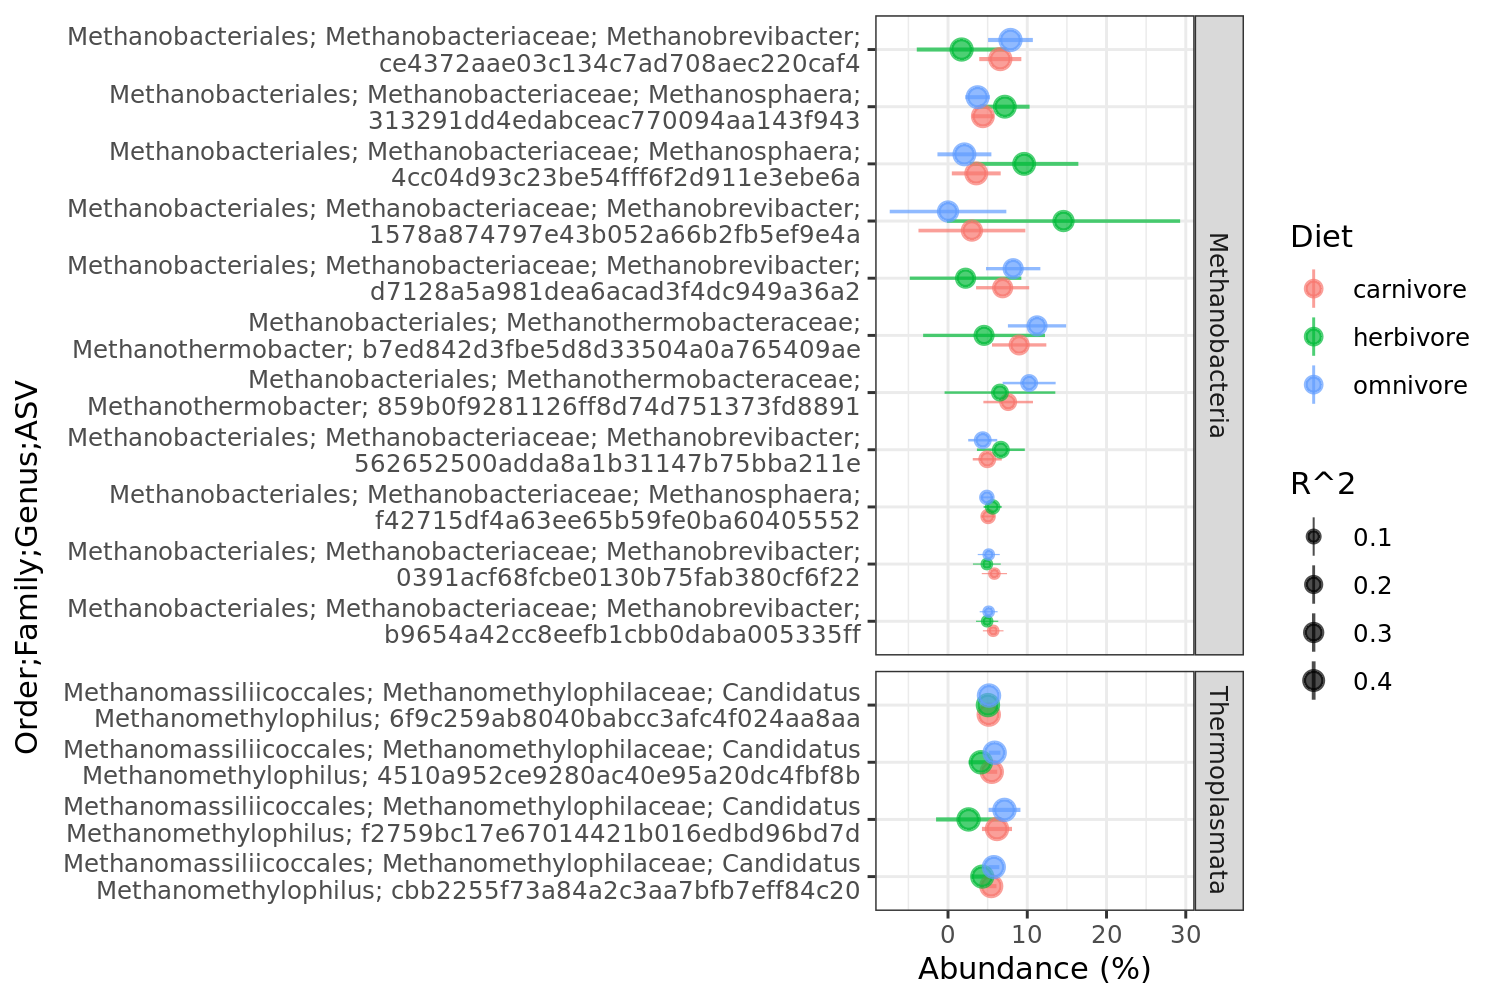

In [54]:
# plotting
p = rrpp_res_j %>%
    mutate(taxon = gsub('^X_', '', taxon)) %>%
    mutate(Taxonomy = paste(Order, Family, Genus, taxon, sep='; '),
           Taxonomy = stringr::str_wrap(Taxonomy, 60)) %>%
    inner_join(X, c('Taxonomy')) %>%
    mutate(delta = ucl - mean,
           mean = scales::rescale(mean, c(0, max(mean))),
           delta = scales::rescale(delta, c(0, max(delta)))) %>%
    mutate(Taxonomy = Taxonomy %>% reorder(mean_Rsq)) %>%
    ggplot(aes(Taxonomy, mean, color=feature)) +
    geom_pointrange(position = position_dodge(width = 0.5),
                    aes(ymin=mean-delta, ymax=mean+delta, size=mean_Rsq), alpha=0.7) +
    scale_size_continuous('R^2', range = c(0.2, 0.7)) +
    scale_color_discrete('Diet') +
    facet_grid(Class ~ ., scales='free_y', space='free_y') +
    labs(x='Order;Family;Genus;ASV', y='Abundance (%)') +
    theme_bw() +
    theme(
        axis.title.y = element_text(hjust = 0.3)
    ) +
    coord_flip()

p.dims(7.5,5)
plot(p)

In [74]:
# for ordering
X = rrpp_res_s_f %>%
    mutate(taxon = gsub('^X_', '', taxon)) %>%
    mutate(taxon = taxon %>% as.factor %>% as.numeric %>% gsub('^', 'ASV-', .)) %>%
    mutate(Taxonomy = paste(Genus, taxon, sep='; ')) %>%
    mutate(Taxonomy = gsub('Methano', 'M-', Taxonomy),
           Taxonomy = gsub('Candidatus ', '', Taxonomy)) %>%
    group_by(Taxonomy) %>%
    summarize(mean_Rsq = median(Rsq), .groups='drop')
X

Taxonomy,mean_Rsq
<chr>,<dbl>
M-brevibacter; ASV-1,0.06508639
M-brevibacter; ASV-10,0.06508639
⋮,⋮
M-thermobacter; ASV-8,0.1531934
M-thermobacter; ASV-9,0.2904823


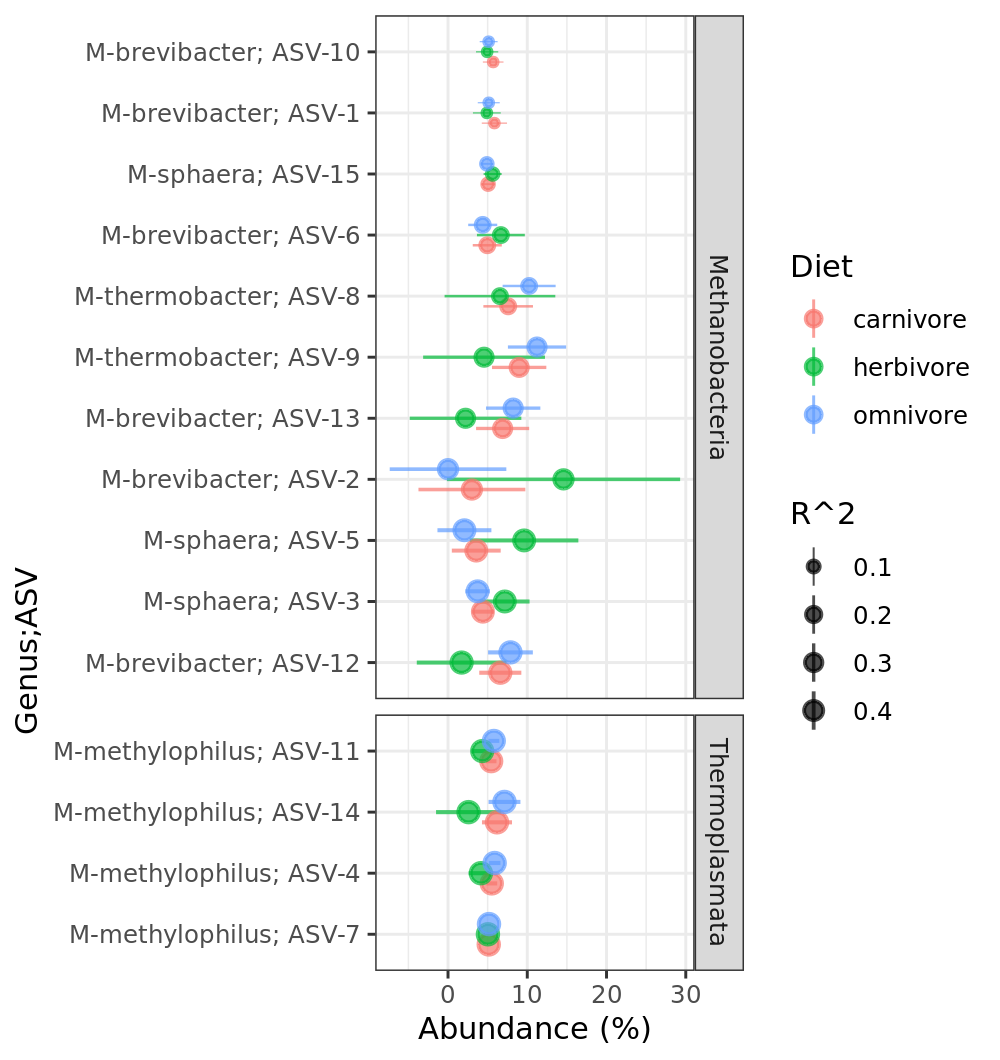

In [91]:
# plotting
p = rrpp_res_j %>%
    mutate(taxon = gsub('^X_', '', taxon)) %>%
    mutate(taxon = taxon %>% as.factor %>% as.numeric %>% gsub('^', 'ASV-', .)) %>%
    #mutate(taxon = taxon %>% as.factor %>% as.numeric %>% gsub('^', 'ASV-', .)) %>%
    mutate(Taxonomy = paste(Genus, taxon, sep='; ')) %>%
    mutate(Taxonomy = gsub('Methano', 'M-', Taxonomy),
           Taxonomy = gsub('Candidatus ', '', Taxonomy)) %>%
    inner_join(X, c('Taxonomy')) %>%
    mutate(delta = ucl - mean,
           mean = scales::rescale(mean, c(0, max(mean))),
           delta = scales::rescale(delta, c(0, max(delta)))) %>%
    mutate(Taxonomy = Taxonomy %>% reorder(-mean_Rsq)) %>%
    ggplot(aes(Taxonomy, mean, color=feature)) +
    geom_pointrange(position = position_dodge(width = 0.5),
                    aes(ymin=mean-delta, ymax=mean+delta, size=mean_Rsq), alpha=0.7) +
    scale_size_continuous('R^2', range = c(0.2, 0.7)) +
    scale_color_discrete('Diet') +
    #facet_grid(. ~ Class, scales='free_x', space='free_x') +
    facet_grid(Class ~ ., scales='free_y', space='free_y') +
    labs(x='Genus;ASV', y='Abundance (%)') +
    theme_bw() +
    theme(
        #axis.text.x = element_text(angle=65, hjust=1),
        axis.title.y = element_text(hjust = 0.3)
    ) +
    coord_flip() 

#p.dims(8.5,4)
p.dims(5,5.3)
plot(p)

# RRPP: digestive system

In [ ]:
.rrpp_digsys = function(tree, taxon, otu, iter=999){
    # tree
    PhyCov = vcv(tree, model = "Brownian")
    # otu
    otu_f = otu[rownames(PhyCov),]
    data = list(OTUs = otu_f[,taxon] %>% as.matrix,
                digestive_system = otu_f$digestive_system)
    names(data[['digestive_system']]) = rownames(otu_f)
    # rrpp
    fitGLS = lm.rrpp(OTUs ~ digestive_system, data = data, Cov = PhyCov,
                     print.progress = FALSE, iter = iter)
    anova(fitGLS)$table
}

rrpp_digsys = function(taxon, otu, trees, iter=999){
    df = trees %>% 
        lapply(.rrpp_digsys, taxon=taxon, otu=otu, iter=iter) %>%
        do.call(rbind, .) %>%
        mutate(feature = gsub('[0-9]+$', '', rownames(.))) %>%
        filter(feature == 'digestive_system') 
    df$taxon = taxon
    return(df)
    
}

In [ ]:
# running for all OTUs & all trees
taxa = physeq %>% taxa_names %>% gsub('^([0-9])', 'X_\\1', .)
taxa %>% length %>% cat('Number of OTUs:', ., '\n')

doParallel::registerDoParallel(threads)
rrpp_res = taxa %>%
    plyr::llply(rrpp_digsys, otu=otu, trees=host_tree_l, iter=999, .parallel=TRUE) %>%
    do.call(rbind, .) %>%
    rename('P' = `Pr(>F)`) 
rrpp_res

## Saving results

In [ ]:
# output file
outF = file.path(work_dir, 'RRPP_lm_otu-digSys_clr.RDS')
outF

In [ ]:
# saving
saveRDS(rrpp_res, outF)
cat('File written:', outF)

In [ ]:
# reload 
rrpp_res = readRDS(outF)
rrpp_res

In [ ]:
send_email('http://127.0.0.1:9705/notebooks/notebooks/16S_arch/MiSeq-Runs116-122-126-189-190/03_modulating_factors/05_RRPP_clr.ipynb')

## Summary

In [ ]:
# formatting
rrpp_res_s = rrpp_res %>%
    group_by(taxon) %>%
    mutate(P = (length(P) - sum(P < 0.05)) / length(P)) %>%
    ungroup() %>%
    mutate(Q = p.adjust(P, method='BH'))

rrpp_res_s %>% .$Q %>% summary_x('Adj. P')
rrpp_res_s

In [ ]:
# significant taxa
tax = physeq %>%
    phyloseq2df(tax_table) %>%
    mutate(OTU = gsub('^([0-9])', 'X_\\1', OTU))

rrpp_res_s_f = rrpp_res_s %>%
    filter(Q < 0.05) %>%
    inner_join(tax, c('taxon'='OTU'))
rrpp_res_s_f

In [ ]:
# plotting
p = rrpp_res_s_f %>%
    mutate(taxon = gsub('^X_', '', taxon)) %>%
    #mutate(taxon = taxon %>% as.factor %>% as.numeric %>% gsub('^', 'ASV-', .)) %>%
    mutate(Taxonomy = paste(Order, Family, Genus, Species, taxon, sep='; '),
           Taxonomy = stringr::str_wrap(Taxonomy, 90)) %>%
    group_by(Taxonomy) %>%
    mutate(mean_Rsq = median(Rsq)) %>%
    ungroup() %>%
    mutate(Taxonomy = Taxonomy %>% reorder(mean_Rsq)) %>%
    ggplot(aes(Taxonomy, Rsq, color=Class)) +
    geom_boxplot() +
    labs(y='R^2') +
    theme_bw() +
    coord_flip()

p.dims(8.5,4)
plot(p)

# RRPP: diet + digSys

In [ ]:
.rrpp_diet_digsys = function(tree, taxon, otu, iter=999){
    # tree
    PhyCov = vcv(tree, model = "Brownian")
    # otu
    otu_f = otu[rownames(PhyCov),]
    data = list(OTUs = otu_f[,taxon] %>% as.matrix,
                diet = otu_f$diet,
                digestive_system = otu_f$digestive_system)
    names(data[['digestive_system']]) = rownames(otu_f)
    # rrpp
    fitGLS = lm.rrpp(OTUs ~ digestive_system + diet, data = data, Cov = PhyCov,
                     print.progress = FALSE, iter = iter)
    anova(fitGLS)$table
}

rrpp_diet_digsys = function(taxon, otu, trees, iter=999){
    df = trees %>% 
        lapply(.rrpp_diet_digsys, taxon=taxon, otu=otu, iter=iter) %>%
        do.call(rbind, .) %>%
        mutate(feature = gsub('[0-9]+$', '', rownames(.))) %>%
        filter(feature %in% c('digestive_system', 'diet'))
    df$taxon = taxon
    return(df)
    
}

In [ ]:
# running for all OTUs & all trees
taxa = physeq %>% taxa_names %>% gsub('^([0-9])', 'X_\\1', .)
taxa %>% length %>% cat('Number of OTUs:', ., '\n')

doParallel::registerDoParallel(threads)
rrpp_res = taxa %>%
    plyr::llply(rrpp_diet_digsys, otu=otu, trees=host_tree_l, iter=999, .parallel=FALSE) %>%
    do.call(rbind, .) %>%
    rename('P' = `Pr(>F)`) 
rrpp_res

## Saving results

In [ ]:
# output file
outF = file.path(work_dir, 'RRPP_lm_otu-digSys-diet_clr.RDS')
outF

In [ ]:
# saving
saveRDS(rrpp_res, outF)
cat('File written:', outF)

In [ ]:
# reload 
rrpp_res = readRDS(outF)
rrpp_res

In [ ]:
send_email('http://127.0.0.1:9705/notebooks/notebooks/16S_arch/MiSeq-Runs116-122-126-189-190/03_modulating_factors/05_RRPP_clr.ipynb')

## Summary

In [ ]:
# formatting
rrpp_res_s = rrpp_res %>%
    group_by(taxon) %>%
    mutate(P = (length(P) - sum(P < 0.05)) / length(P)) %>%
    ungroup() %>%
    mutate(Q = p.adjust(P, method='BH'))

rrpp_res_s %>% .$Q %>% summary_x('Adj. P')
rrpp_res_s

In [ ]:
# significant taxa
tax = physeq %>%
    phyloseq2df(tax_table) %>%
    mutate(OTU = gsub('^([0-9])', 'X_\\1', OTU))

rrpp_res_s_f = rrpp_res_s %>%
    filter(Q < 0.05) %>%
    inner_join(tax, c('taxon'='OTU'))
rrpp_res_s_f

# sessionInfo

In [ ]:
sessionInfo()